In [20]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool, cv
import catboost
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import log_loss

In [13]:
!pip install xgboost
!pip install lightgbm
!pip install catboost

     ---------------------------------------- 99.7/99.7 MB 6.2 MB/s eta 0:00:00
     ---------------------------------------- 1.3/1.3 MB 5.2 MB/s eta 0:00:00
     -------------------------------------- 101.0/101.0 MB 5.6 MB/s eta 0:00:00
     ---------------------------------------- 47.0/47.0 kB 1.2 MB/s eta 0:00:00


Dataset Info.

1. train.csv

train 데이터 : 2019년 01월 01일부터 2023년 03월 03일까지의 유통된 품목의 가격 데이터
item: 품목 코드
TG : 감귤
BC : 브로콜리
RD : 무
CR : 당근
CB : 양배추
corporation : 유통 법인 코드
법인 A부터 F 존재
location : 지역 코드
J : 제주도 제주시
S : 제주도 서귀포시
supply(kg) : 유통된 물량, kg 단위
price(원/kg) : 유통된 품목들의 kg 마다의 가격, 원 단위


2. international_trade.csv

관련 품목 수출입 정보
중량 단위 kg
금액 단위 천 달러


3. test.csv

test 데이터 : 2023년 03월 04일부터 2023년 03월 31일까지의 데이터


4. sample_submission.csv

제출을 위한 양식
2023년 03월 04일부터 2023년 03월 31일까지의 price(원/kg)을 예측
ID는 품목, 유통 법인, 지역 코드로 구성된 식별자
해당 ID에 맞춰 price(원/kg) 예측값을 answer 컬럼에 기입해야 함

In [3]:
os.getcwd()

'C:\\Users\\eunse'

In [4]:
directory = 'C:/Users/eunse/Downloads/open (1)/open'
os.chdir(directory)

In [5]:
os.getcwd()

'C:\\Users\\eunse\\Downloads\\open (1)\\open'

## 데이터 불러오기

In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
trade = pd.read_csv('international_trade.csv')

train.head()
test.head()
trade.head()

,기간,품목명,수출 중량,수출 금액,수입 중량,수입 금액,무역수지
0,2019-01,토마토(신선한 것이나 냉장한 것으로 한정한다),356571,990,0,0,990
1,2019-01,양파,821330,222,4003206,1118,-896
2,2019-01,쪽파,60,1,93405,128,-127
3,2019-01,꽃양배추와 브로콜리(broccoli),160,1,638913,563,-562
4,2019-01,방울다다기 양배추,0,0,7580,38,-38


In [16]:
train.head()   #날짜데이터 2019-01-01 ~ 2023-03-03 

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0


In [7]:
train.tail()

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
59392,RD_F_J_20230227,2023-02-27,RD,F,J,452440.0,468.0
59393,RD_F_J_20230228,2023-02-28,RD,F,J,421980.0,531.0
59394,RD_F_J_20230301,2023-03-01,RD,F,J,382980.0,574.0
59395,RD_F_J_20230302,2023-03-02,RD,F,J,477220.0,523.0
59396,RD_F_J_20230303,2023-03-03,RD,F,J,427520.0,529.0


In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59397 entries, 0 to 59396
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ID           59397 non-null  object        
 1   timestamp    59397 non-null  datetime64[ns]
 2   item         59397 non-null  object        
 3   corporation  59397 non-null  object        
 4   location     59397 non-null  object        
 5   supply(kg)   59397 non-null  float64       
 6   price(원/kg)  59397 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 3.2+ MB


In [15]:
# 'date'를 제외한 컬럼 저장하기
# 'timestamp' 컬럼을 datetime 타입으로 변경
train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

train.head()

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0


In [52]:
# 날짜 관련 feature 추가 하기

train['year'] = train['timestamp'].dt.year
train['month'] = train['timestamp'].dt.month
train['week'] = train['timestamp'].dt.isocalendar().week.astype(np.int32)
train['weekday']  = train['timestamp'].dt.weekday

# 날짜 관련 피처를 저장해 둔다.
features_date = ['month', 'week', 'weekday']

In [16]:
train['item'].value_counts()

TG    15230
BC    13707
RD    12184
CR    10661
CB     7615
Name: item, dtype: int64

In [17]:
train.describe()

,supply(kg),price(원/kg)
count,5.939700e+04,59397.000000
mean,1.189453e+04,1131.680674
std,5.226400e+04,2029.941445
min,0.000000e+00,0.000000
25%,0.000000e+00,0.000000
50%,0.000000e+00,0.000000
75%,3.800000e+03,1519.000000
max,1.222800e+06,20909.000000


In [18]:
# 컬럼명 변경
train = train.rename(columns = {'price(원/kg)' : 'price', 'supply(kg)' : 'supply'})
train

,ID,timestamp,item,corporation,location,supply,price
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0
...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,2023-02-27,RD,F,J,452440.0,468.0
59393,RD_F_J_20230228,2023-02-28,RD,F,J,421980.0,531.0
59394,RD_F_J_20230301,2023-03-01,RD,F,J,382980.0,574.0
59395,RD_F_J_20230302,2023-03-02,RD,F,J,477220.0,523.0


## 데이터 시각화

In [27]:
print(train.price.describe(percentiles = [0.25,0.50,0.75,0.85,0.90,1]))

count    59397.000000
mean      1131.680674
std       2029.941445
min          0.000000
25%          0.000000
50%          0.000000
75%       1519.000000
85%       2748.600000
90%       4219.000000
100%     20909.000000
max      20909.000000
Name: price, dtype: float64


C:\Users\eunse\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


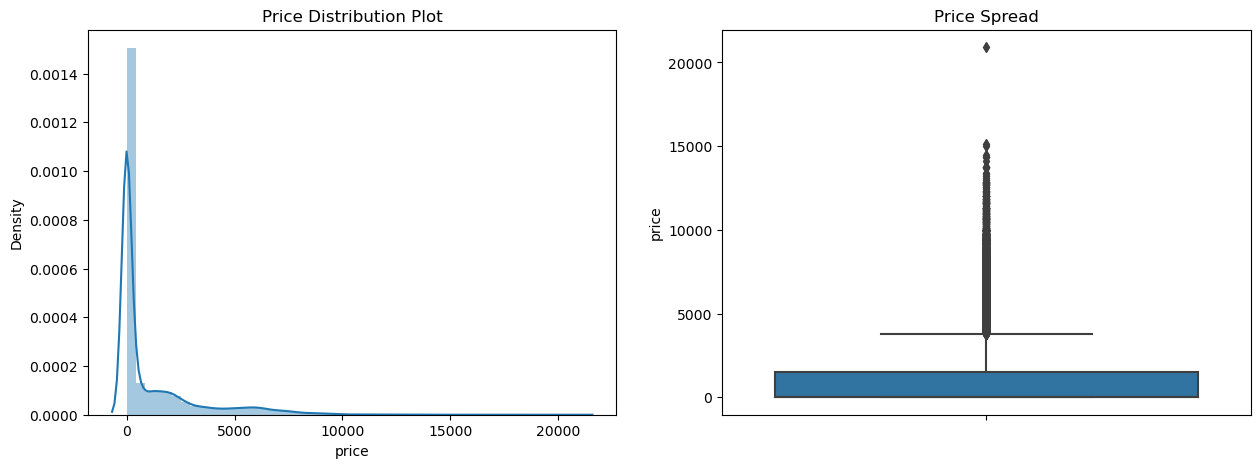

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title('Price Distribution Plot')
sns.distplot(train.price)

plt.subplot(1,2,2)
plt.title('Price Spread')
sns.boxplot(y=train.price)

plt.show()


품목 분할 x price 분포

C:\Users\eunse\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\eunse\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\eunse\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

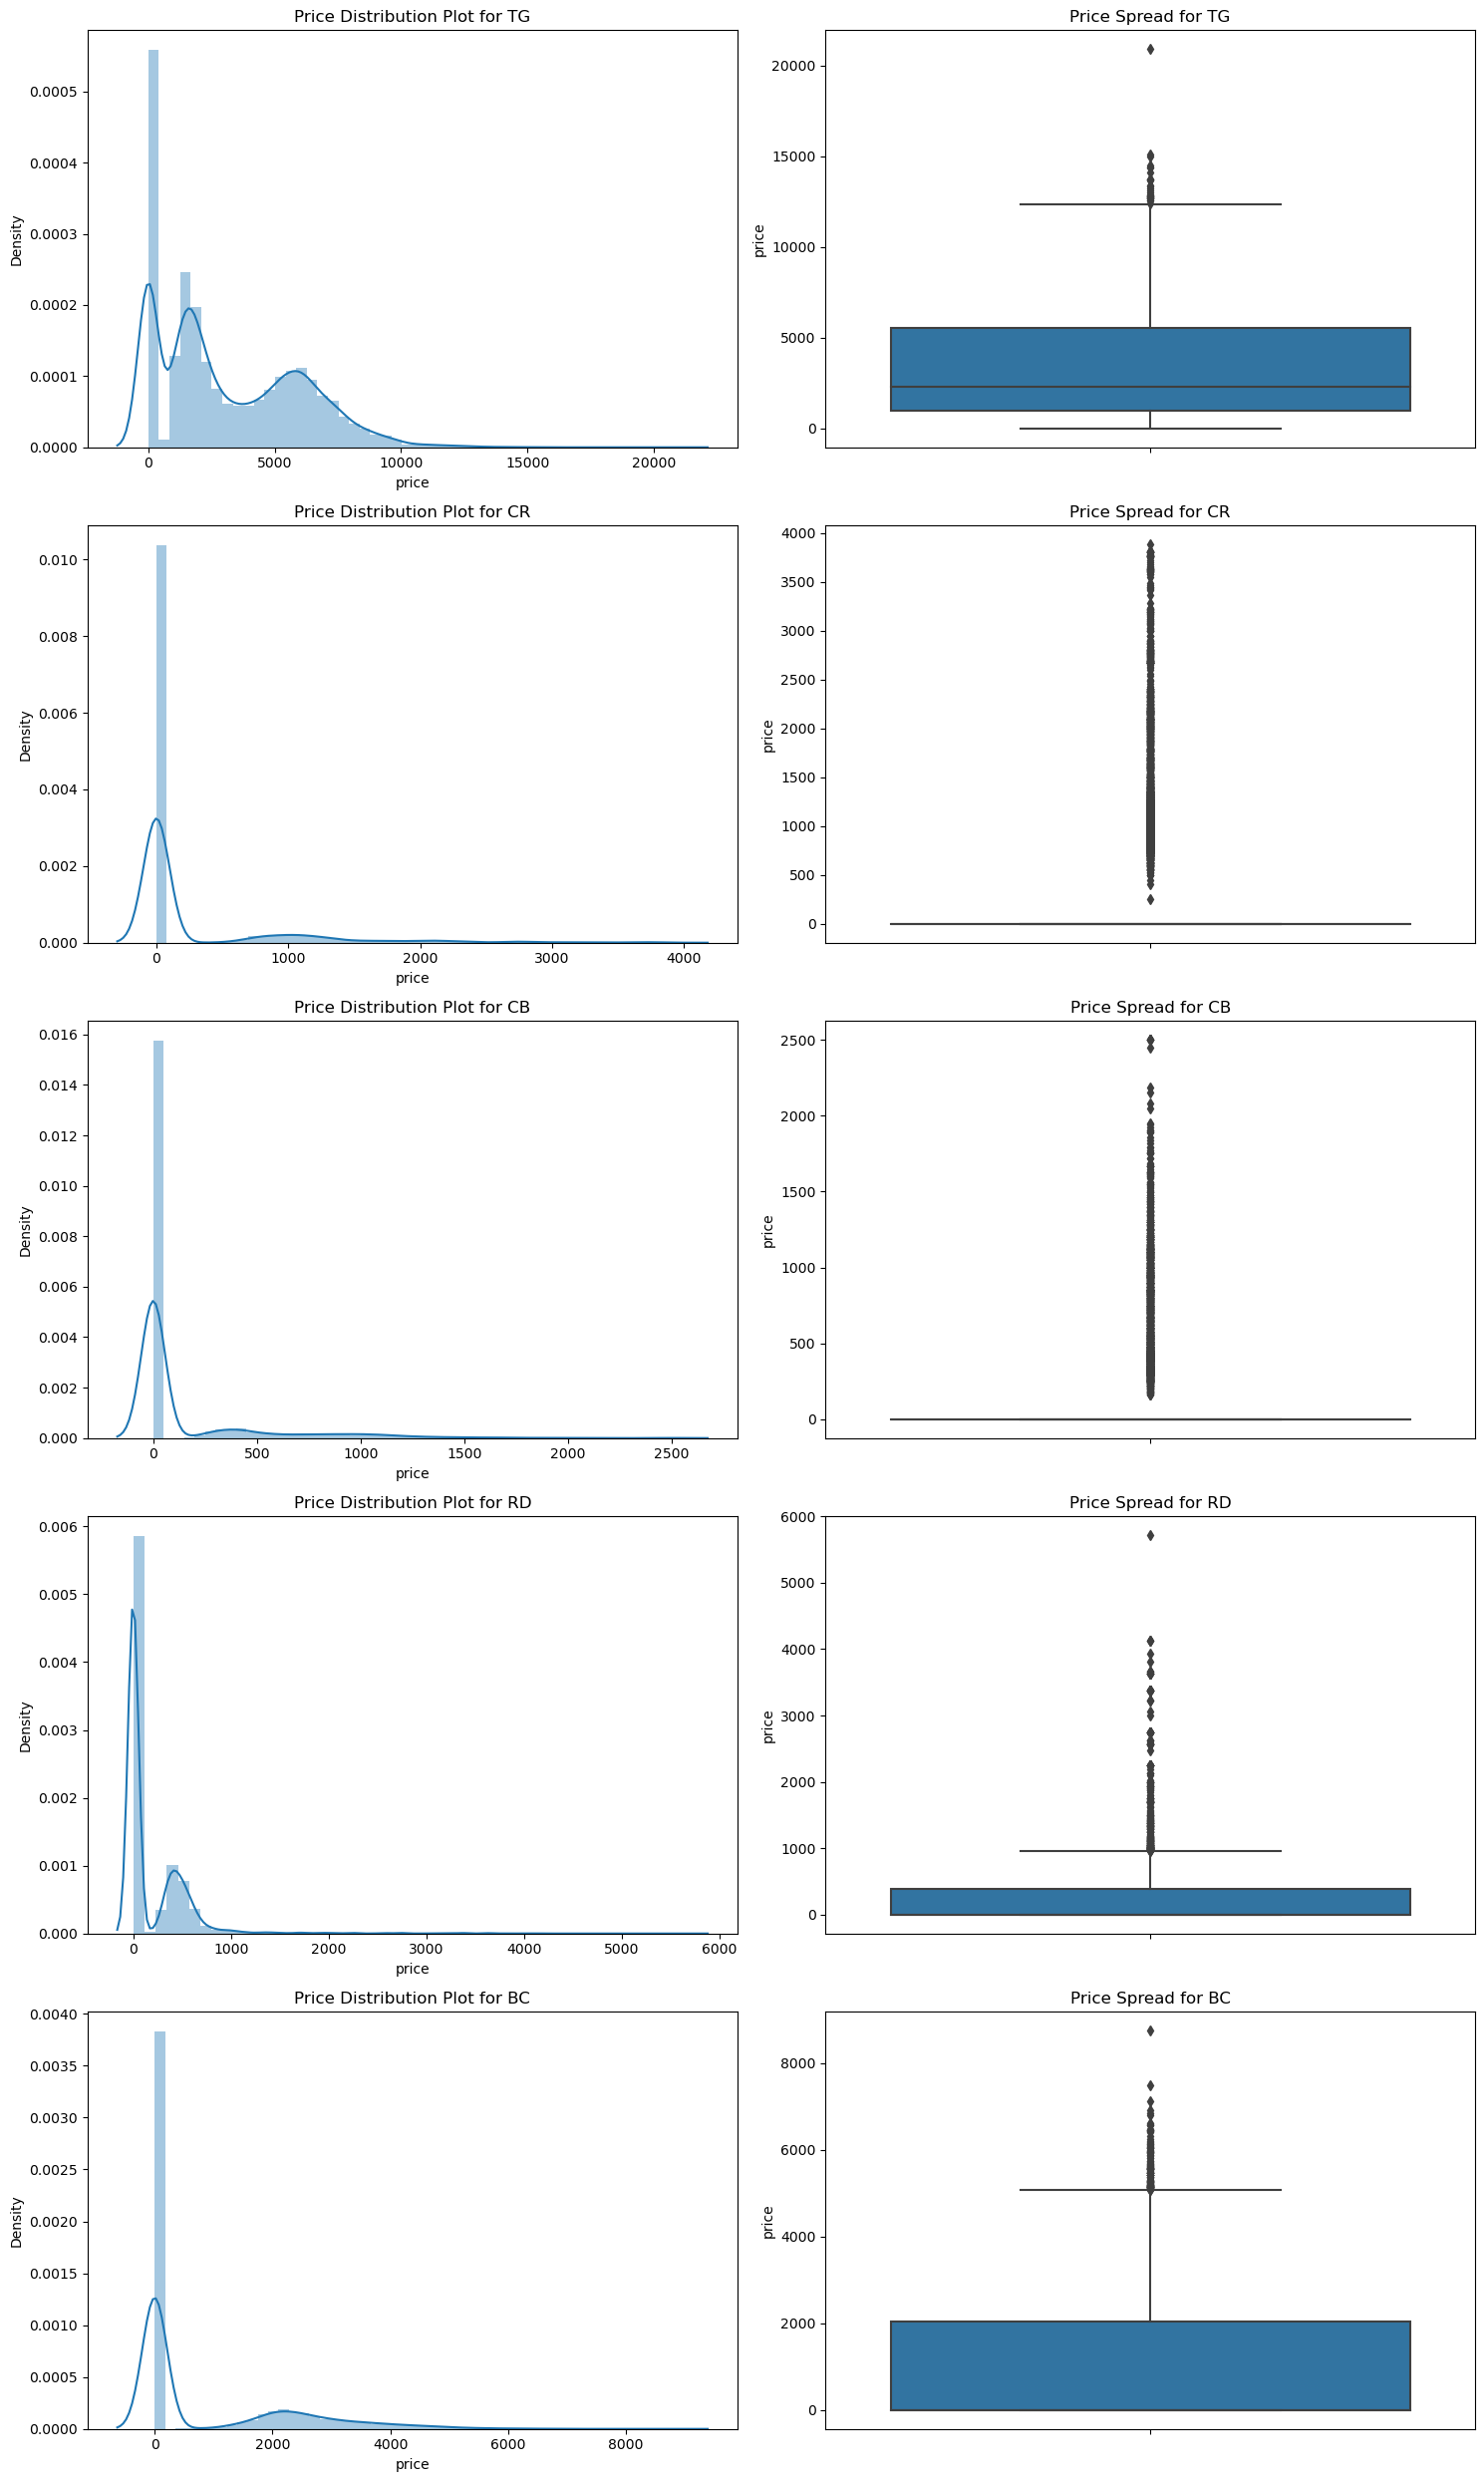

In [28]:
# train 데이터에서 각 품목별로 분할
items = train['item'].unique()

plt.figure(figsize=(15, 5 * len(items)))

for i, item in enumerate(items, 1):
    plt.subplot(len(items), 2, 2 * i - 1)
    plt.title(f'Price Distribution Plot for {item}')
    sns.distplot(train[train['item'] == item]['price'])
    
    plt.subplot(len(items), 2, 2 * i)
    plt.title(f'Price Spread for {item}')
    sns.boxplot(y=train[train['item'] == item]['price'])

plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='item', ylabel='price'>

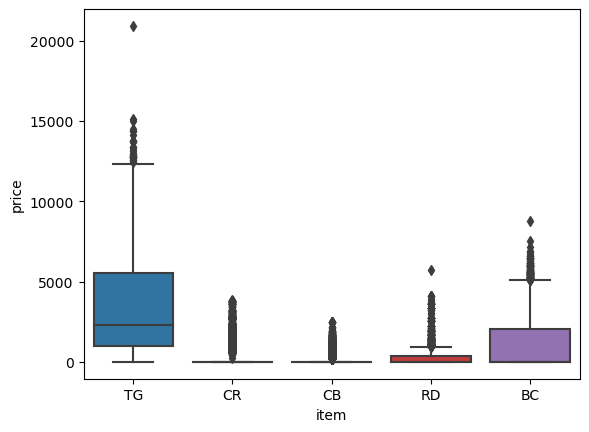

In [30]:
sns.boxplot(x='item',y='price',data=train)

<AxesSubplot:xlabel='corporation', ylabel='price'>

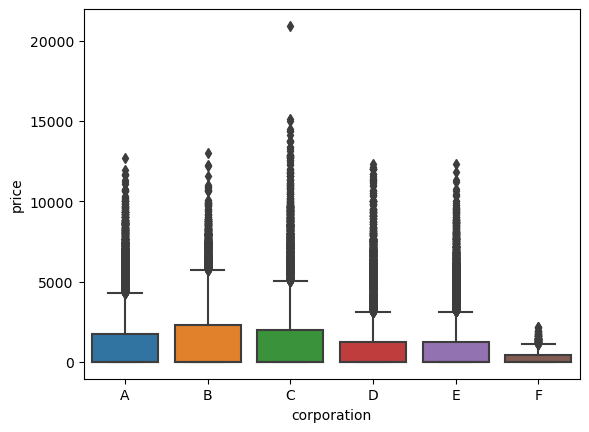

In [33]:
sns.boxplot(x='corporation',y='price',data=train)

<AxesSubplot:xlabel='supply', ylabel='price'>

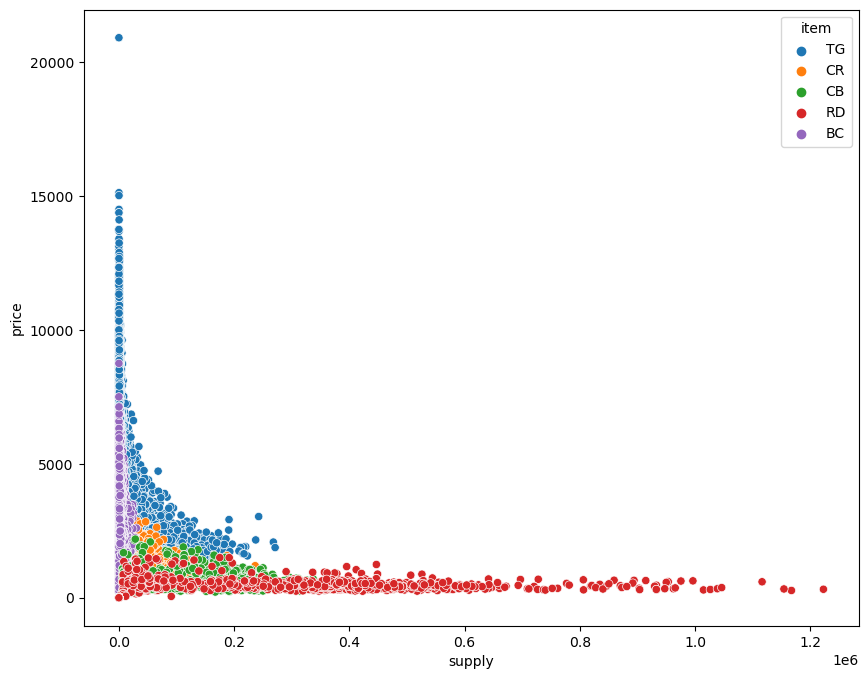

In [34]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=train,x ='supply',y='price',hue='item')

In [41]:
train.groupby('item')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
item,,,,,,,,
BC,13707.0,910.196615,1422.148301,0.0,0.00,0.0,2032.50,8750.0
CB,7615.0,152.187131,345.053036,0.0,0.00,0.0,0.00,2500.0
CR,10661.0,273.118938,632.929933,0.0,0.00,0.0,0.00,3882.0
RD,12184.0,187.073539,358.150266,0.0,0.00,0.0,383.00,5715.0
TG,15230.0,3177.442022,2805.240092,0.0,992.25,2273.5,5532.75,20909.0


In [42]:
train.groupby('item')['price'].sum()

item
BC    12476065.0
CB     1158905.0
CR     2911721.0
RD     2279304.0
TG    48392442.0
Name: price, dtype: float64

<AxesSubplot:xlabel='supply', ylabel='price'>

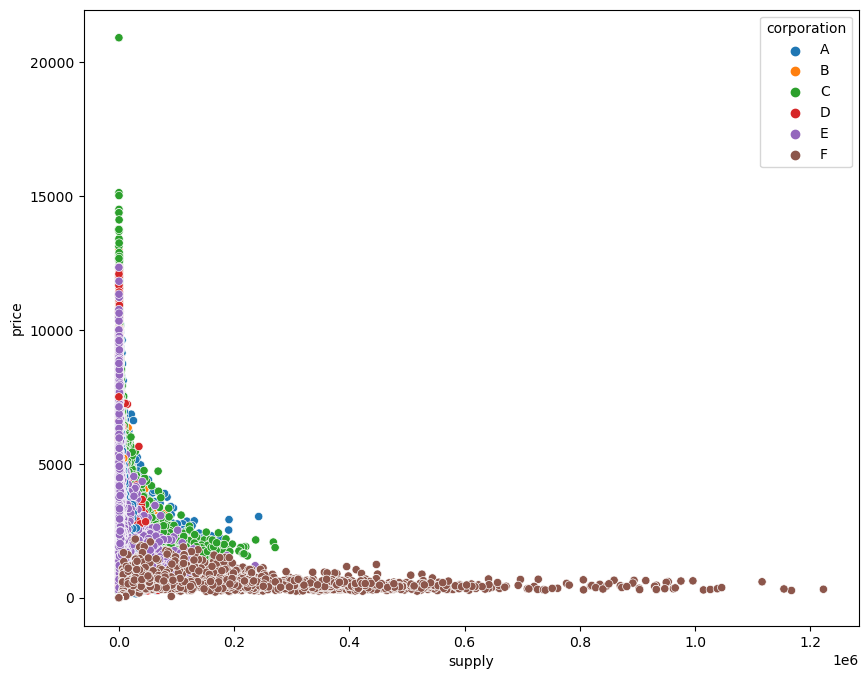

In [35]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=train,x ='supply',y='price',hue='corporation')

In [39]:
train.groupby('corporation')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
corporation,,,,,,,,
A,13707.0,1141.704458,1963.913065,0.0,0.0,0.0,1712.00,12665.0
B,7615.0,1544.736179,2344.967575,0.0,0.0,0.0,2288.00,13000.0
C,9138.0,1468.417159,2525.616068,0.0,0.0,0.0,2012.00,20909.0
D,12184.0,1025.189511,1917.189163,0.0,0.0,0.0,1232.25,12333.0
E,13707.0,956.251404,1737.371106,0.0,0.0,0.0,1254.50,12333.0
F,3046.0,259.121799,348.402146,0.0,0.0,0.0,447.00,2189.0


In [40]:
train.groupby('corporation')['price'].sum()

corporation
A    15649343.0
B    11763166.0
C    13418396.0
D    12490909.0
E    13107338.0
F      789285.0
Name: price, dtype: float64

<AxesSubplot:xlabel='supply', ylabel='price'>

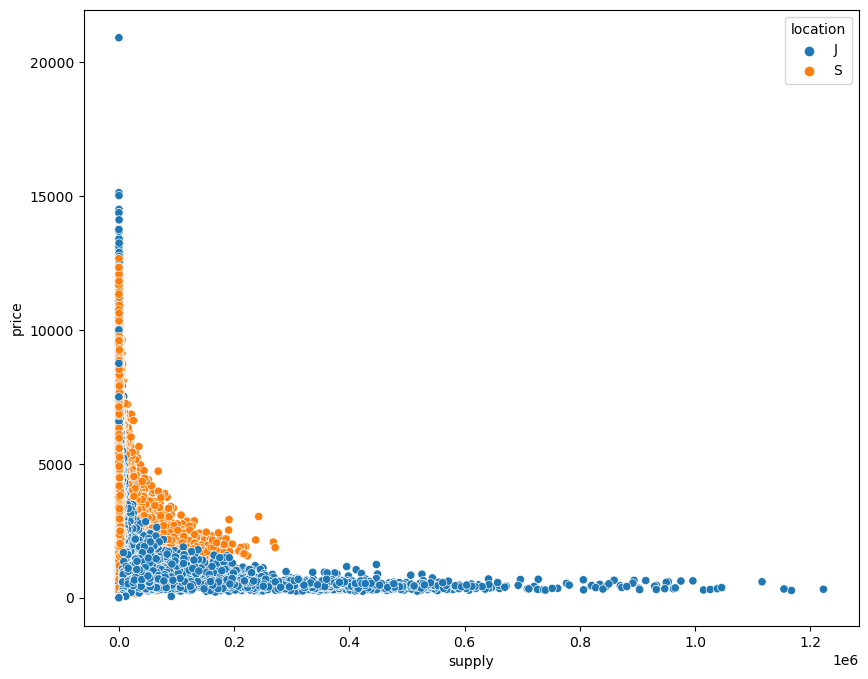

In [36]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=train,x ='supply',y='price',hue='location')

In [38]:
train.groupby('location')['price'].sum()

location
J    37213110.0
S    30005327.0
Name: price, dtype: float64

In [43]:
train.groupby('location')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
J,35029.0,1062.35148,1959.096959,0.0,0.0,0.0,1344.0,20909.0
S,24368.0,1231.34139,2123.731052,0.0,0.0,0.0,1823.0,12667.0


In [46]:
train[['supply','price']].corr()

,supply,price
supply,1.000000,-0.002297
price,-0.002297,1.000000


<AxesSubplot:xlabel='month', ylabel='price'>

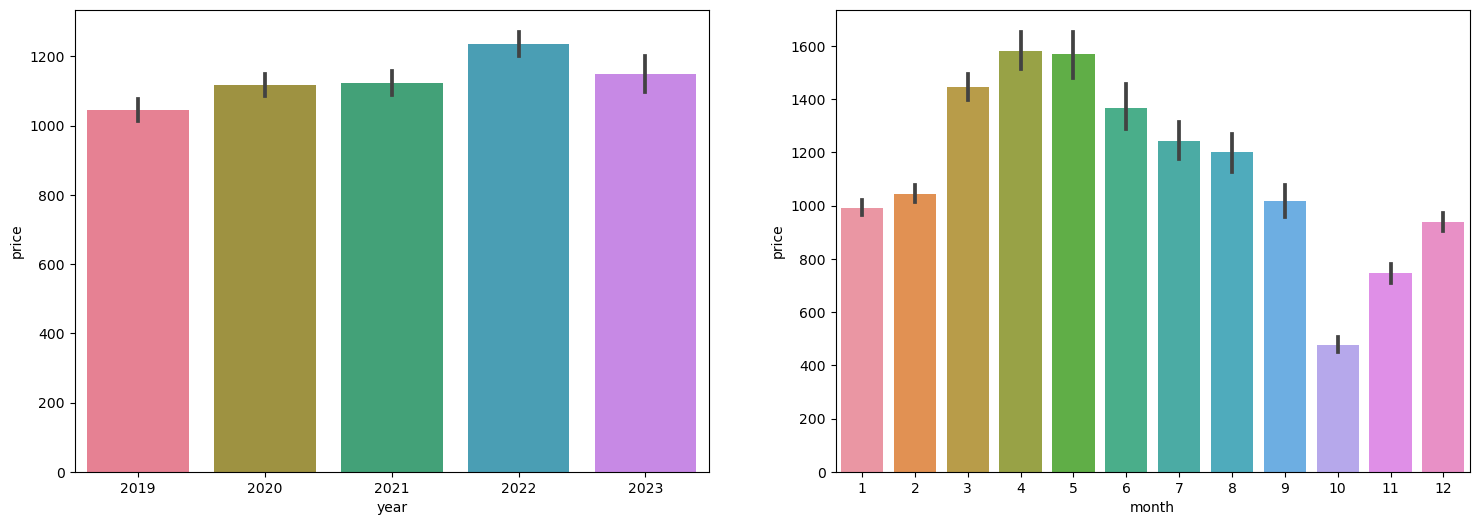

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.barplot(data=train,x='year',y='price',ax=axes[0],palette='husl')
sns.barplot(data=train,x='month',y='price',ax=axes[1])


<AxesSubplot:xlabel='weekday', ylabel='price'>

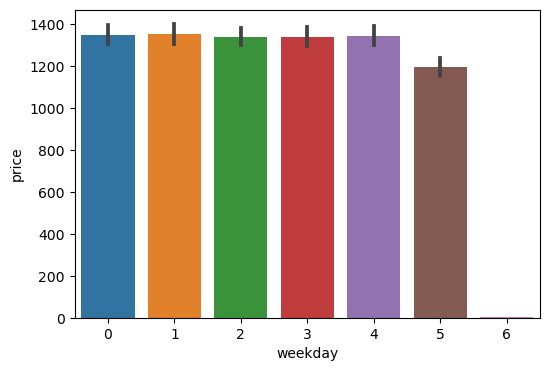

In [58]:
plt.figure(figsize=(6,4))
sns.barplot(data=train,x='weekday',y='price') #0부터 월~일

### 품목별 연/월 가격 barplot

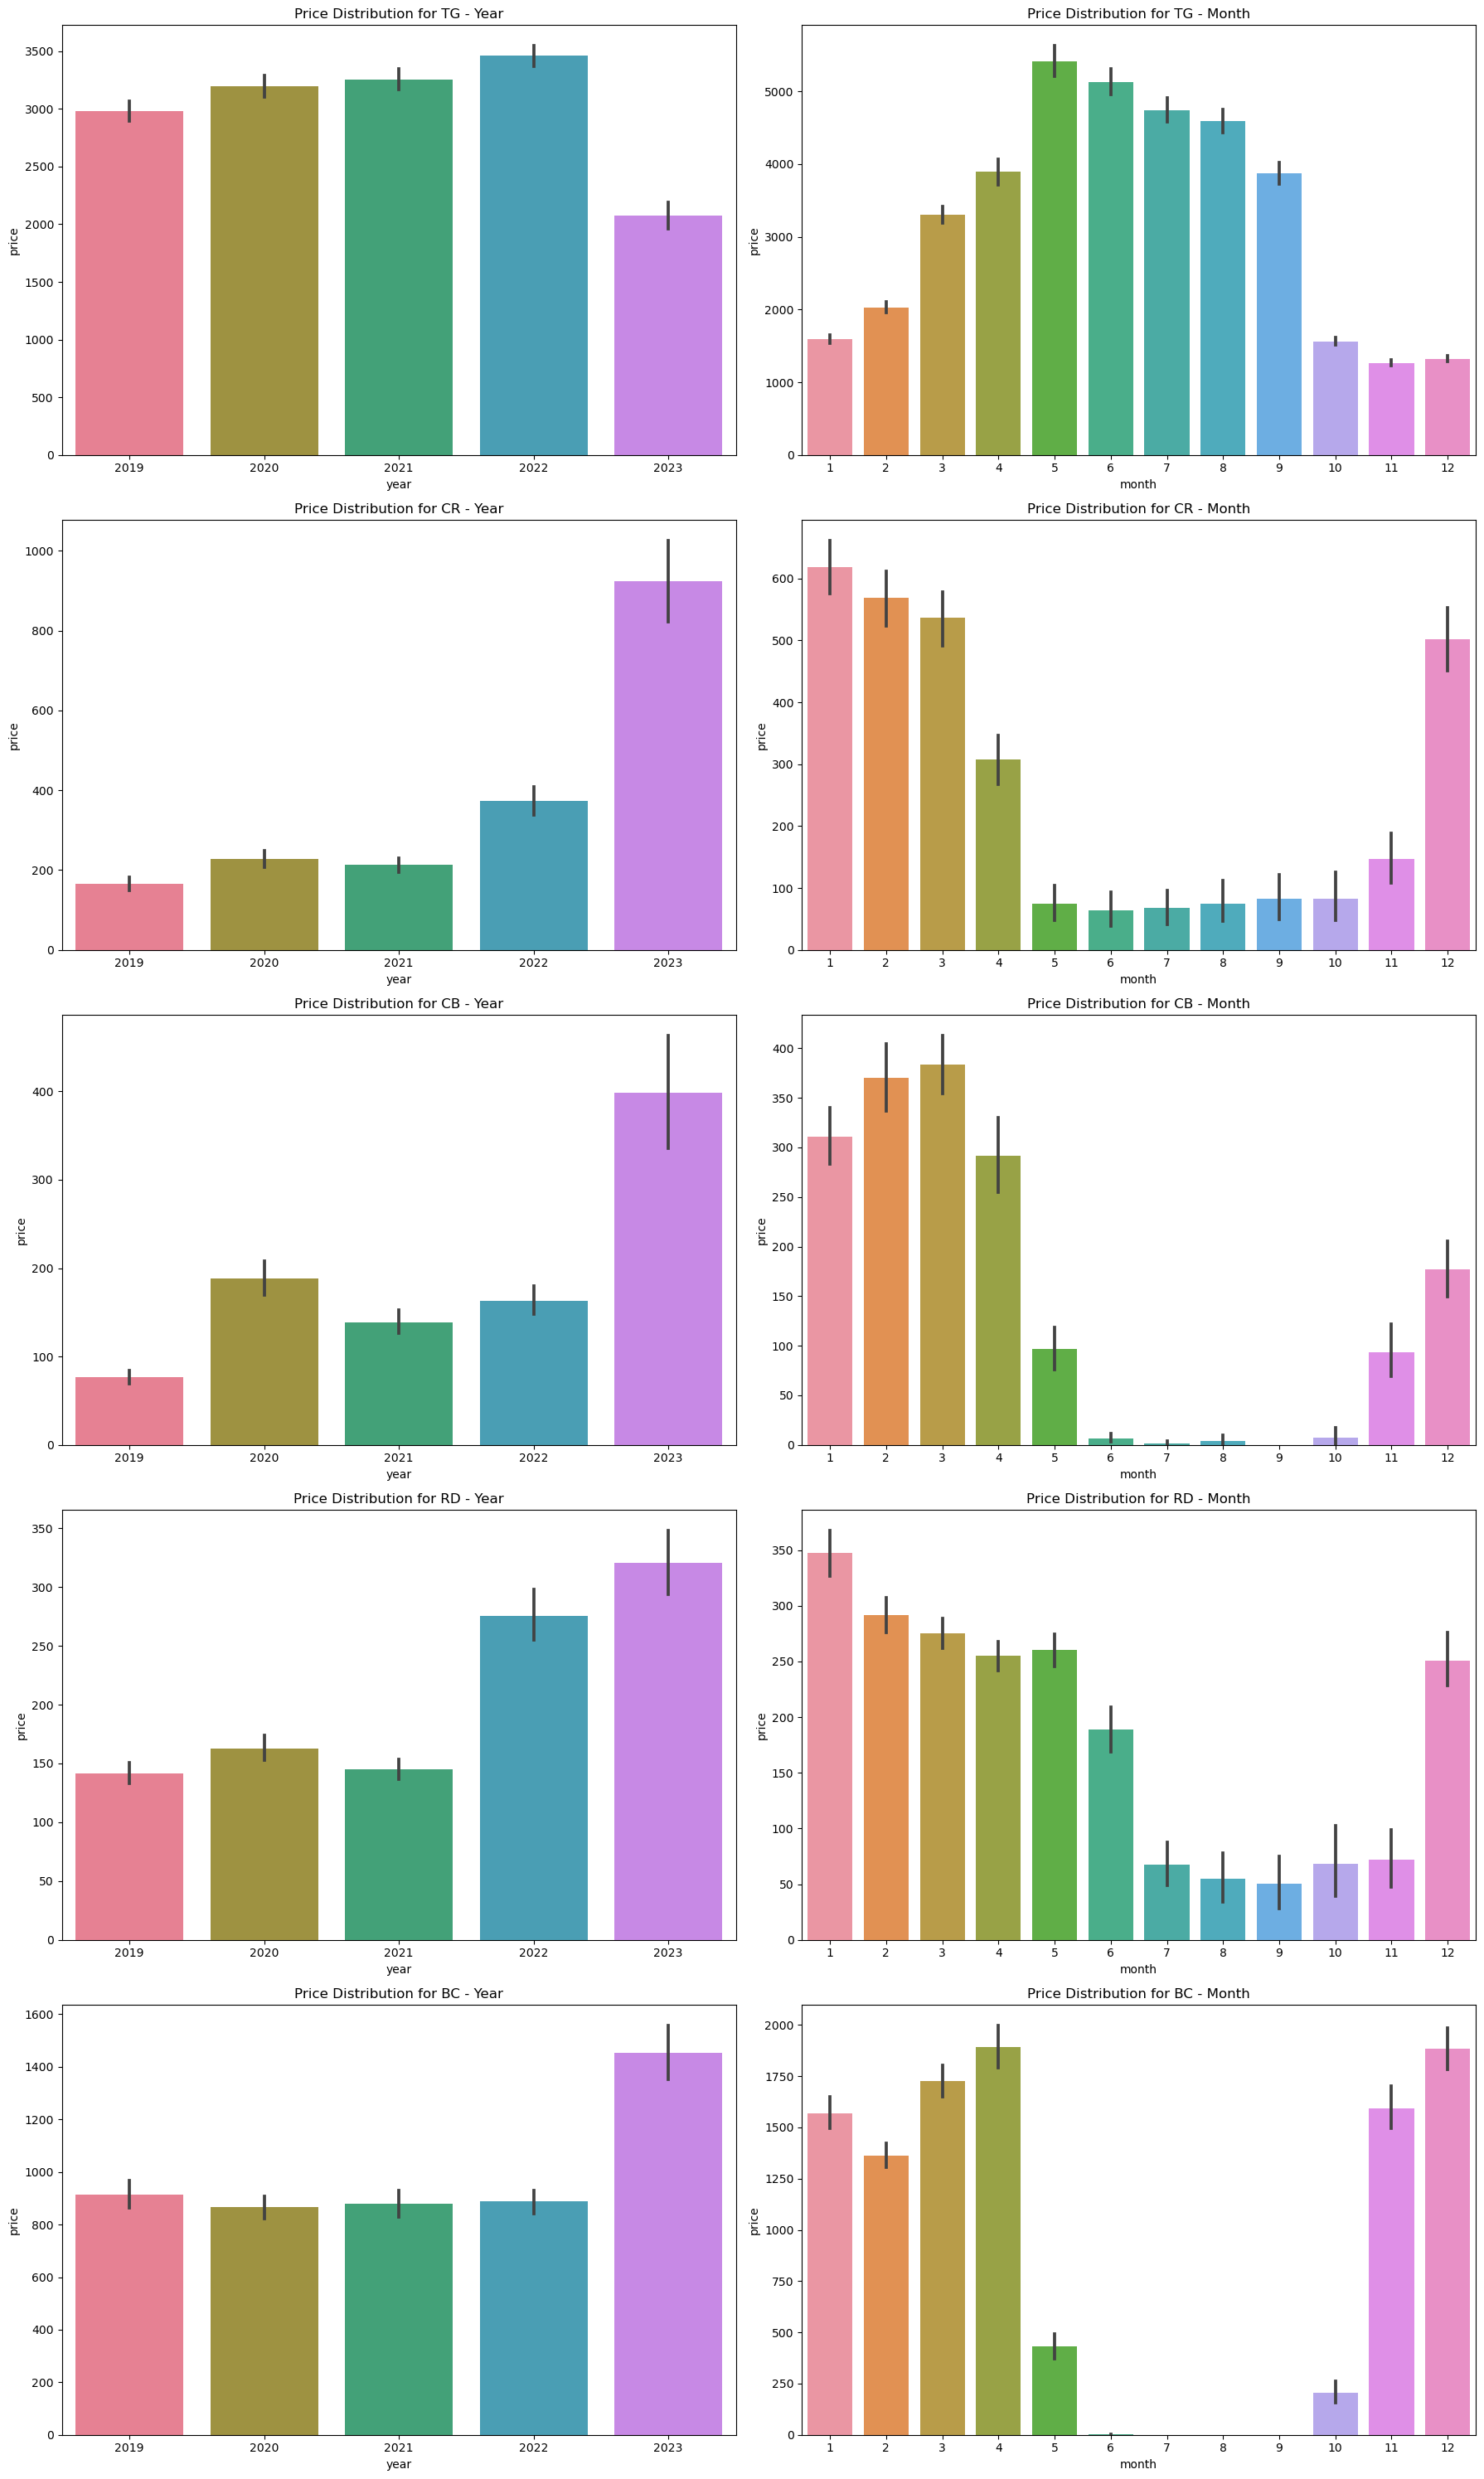

In [60]:
# train 데이터에서 각 품목별로 분할
items = train['item'].unique()

# 서브플롯의 개수 설정
num_subplots = len(items)

# 전체 그림 크기 설정
fig, axes = plt.subplots(num_subplots, 2, figsize=(18, 6 * num_subplots))

# 각 품목에 대한 시각화
for i, item in enumerate(items):
    # 해당 품목의 데이터 추출
    item_data = train[train['item'] == item]

    # 첫 번째 서브플롯: 연도별 가격
    sns.barplot(data=item_data, x='year', y='price', ax=axes[i][0], palette='husl')
    axes[i][0].set_title(f'Price Distribution for {item} - Year')

    # 두 번째 서브플롯: 월별 가격
    sns.barplot(data=item_data, x='month', y='price', ax=axes[i][1])
    axes[i][1].set_title(f'Price Distribution for {item} - Month')

# 레이아웃 조정
plt.tight_layout()
plt.show()


### 품목별 요일 barplot

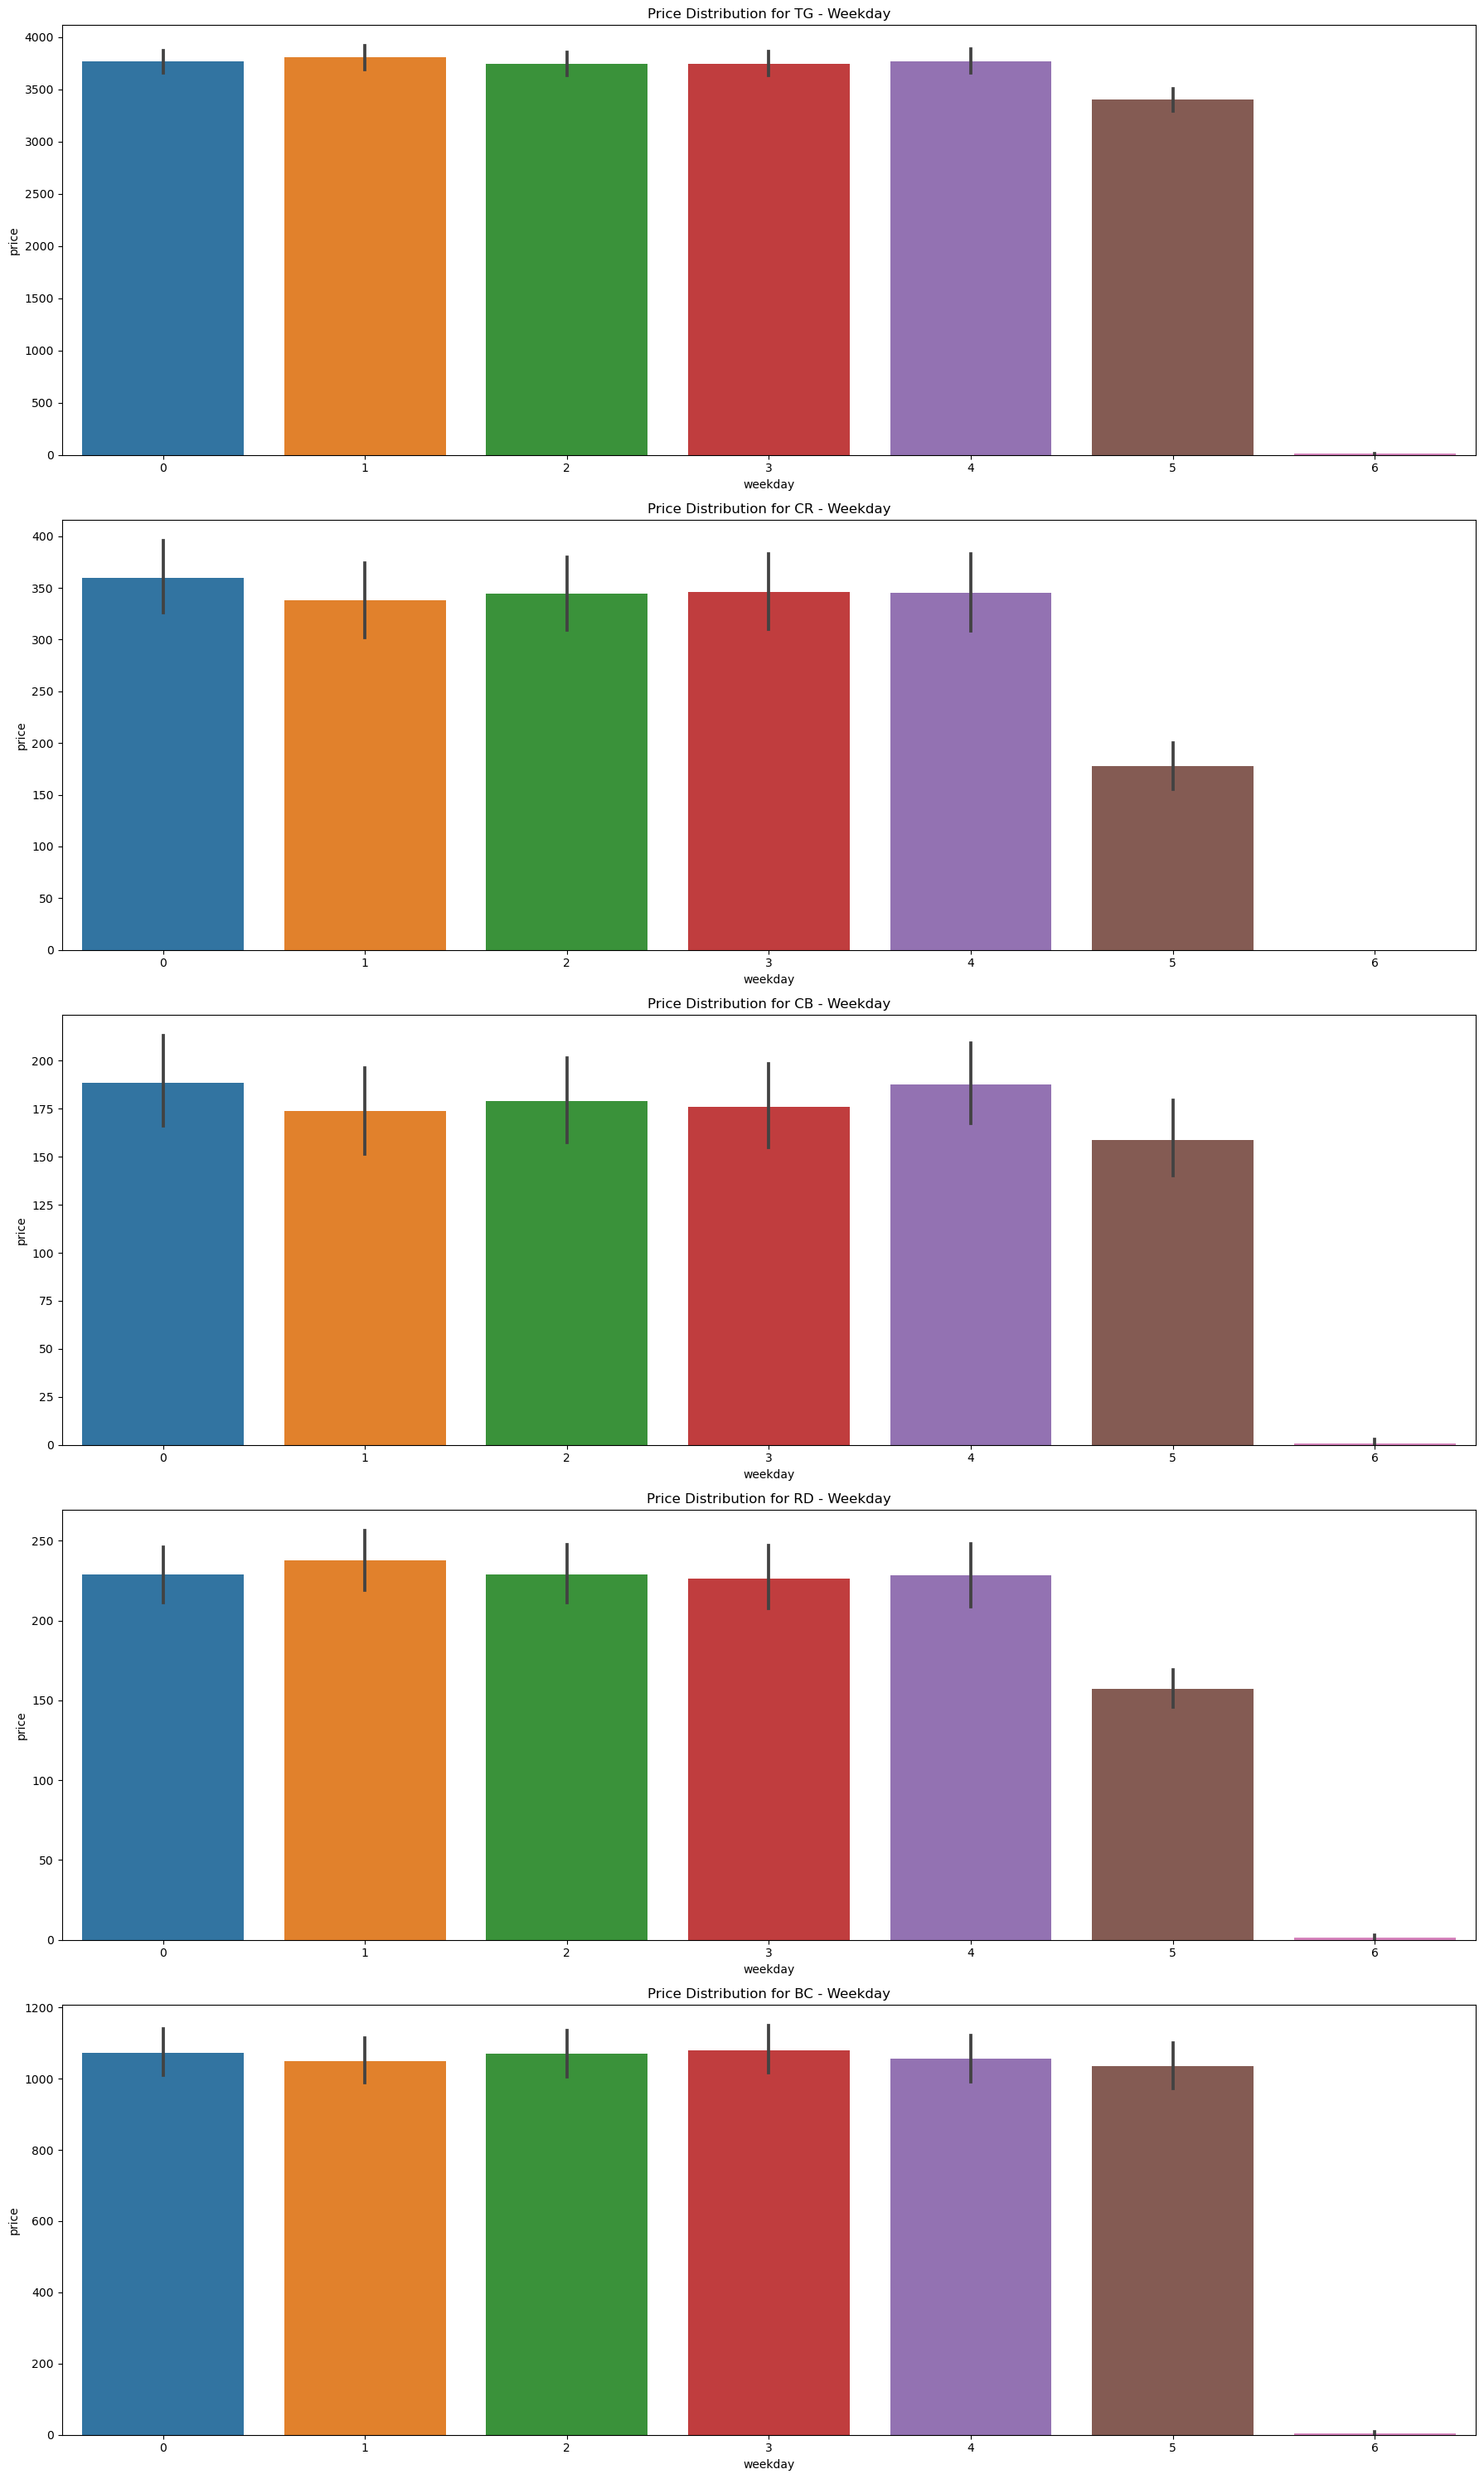

In [61]:
# train 데이터에서 각 품목별로 분할
items = train['item'].unique()

plt.figure(figsize=(18, 6 * len(items)))

# 각 품목에 대한 시각화
for i, item in enumerate(items, 1):
    plt.subplot(len(items), 1, i)
    plt.title(f'Price Distribution for {item} - Weekday')
    item_data = train[train['item'] == item]
    sns.barplot(data=item_data, x='weekday', y='price')

# 레이아웃 조정
plt.tight_layout()
plt.show()

In [ ]:
### EDA 예시 봤는데 supply 0 넣은거랑 뺸거랑 별 차이가 없다고 하긴 함...
### 그리고 휴일 여부에 따라서 차이가 있어서 해바야 할 듯!!

In [17]:
test.head()  #2023-03-04 ~ 2023-03-31 기간 가격 예측

,ID,timestamp,item,corporation,location
0,TG_A_J_20230304,2023-03-04,TG,A,J
1,TG_A_J_20230305,2023-03-05,TG,A,J
2,TG_A_J_20230306,2023-03-06,TG,A,J
3,TG_A_J_20230307,2023-03-07,TG,A,J
4,TG_A_J_20230308,2023-03-08,TG,A,J


In [18]:
trade.head() #2019-01 ~ 2023-02 수출입 데이터

,기간,품목명,수출 중량,수출 금액,수입 중량,수입 금액,무역수지
0,2019-01,토마토(신선한 것이나 냉장한 것으로 한정한다),356571,990,0,0,990
1,2019-01,양파,821330,222,4003206,1118,-896
2,2019-01,쪽파,60,1,93405,128,-127
3,2019-01,꽃양배추와 브로콜리(broccoli),160,1,638913,563,-562
4,2019-01,방울다다기 양배추,0,0,7580,38,-38


In [20]:
trade.tail()

,기간,품목명,수출 중량,수출 금액,수입 중량,수입 금액,무역수지
1269,2023-02,포포(papaw)[파파야(papaya)],0,0,23830,71,-71
1270,2023-02,사과,135165,351,0,0,351
1271,2023-02,배,2206012,5411,1,0,5411
1272,2023-02,신 체리[프루너스 체라서스(Prunus cerasus)],5,0,0,0,0
1273,2023-02,자두,0,0,2,0,0


## 전체 train 데이터에서 실제 학습기간 및 품목 설정

In [41]:
# 연-월 혹은 연-월-일 설정
start_date_train = '2019-01-01'
train_selected = train[train['timestamp'] >= start_date_train].copy().reset_index(drop=True)

#  품목 선택
item_selected = 'CB' #양배추 선택

## Feature engineering

### (1) 날짜 관련 feature 추가

In [33]:
# 날짜 관련 feature 추가 하기

train_selected['month'] = train_selected['timestamp'].dt.month
train_selected['week'] = train_selected['timestamp'].dt.isocalendar().week.astype(np.int32)
train_selected['weekday']  = train_selected['timestamp'].dt.weekday

# 날짜 관련 피처를 저장해 둔다.
features_date = ['month', 'week', 'weekday']

display(train_selected.columns)

Index(['ID', 'timestamp', 'item', 'corporation', 'location', 'supply(kg)',
       'price(원/kg)', 'month', 'week', 'weekday'],
      dtype='object')

,ID,timestamp,item,corporation,location,supply,price
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0
...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,2023-02-27,RD,F,J,452440.0,468.0
59393,RD_F_J_20230228,2023-02-28,RD,F,J,421980.0,531.0
59394,RD_F_J_20230301,2023-03-01,RD,F,J,382980.0,574.0
59395,RD_F_J_20230302,2023-03-02,RD,F,J,477220.0,523.0


### (2) 7일 차분 가격중 자기 상관성 높은 데이터 피처로 생성


In [45]:
# 양배추 선택
cabbage = train[train['item'] == 'CB']\

# 날짜 기준 정렬
cabbage['timestamp'] = pd.to_datetime(cabbage['timestamp'])
cabbage = cabbage.sort_values('timestamp')

# 7일 차분 적용
cabbage['price_diff_7'] = cabbage['price'].diff(7)

# 결과 확인
print(cabbage[['timestamp', 'price', 'price_diff_7']])

       timestamp  price  price_diff_7
25891 2019-01-01    0.0           NaN
27414 2019-01-01    0.0           NaN
28937 2019-01-01    0.0           NaN
30460 2019-01-01    0.0           NaN
56351 2019-01-01    0.0           NaN
...          ...    ...           ...
28936 2023-03-03  848.0          50.0
30459 2023-03-03  780.0         780.0
31982 2023-03-03    0.0        -653.0
27413 2023-03-03    0.0        -858.0
57873 2023-03-03  643.0         643.0

[7615 rows x 3 columns]


C:\Users\eunse\AppData\Local\Temp\ipykernel_12412\3023075513.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cabbage['timestamp'] = pd.to_datetime(cabbage['timestamp'])


C:\Users\eunse\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
C:\Users\eunse\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


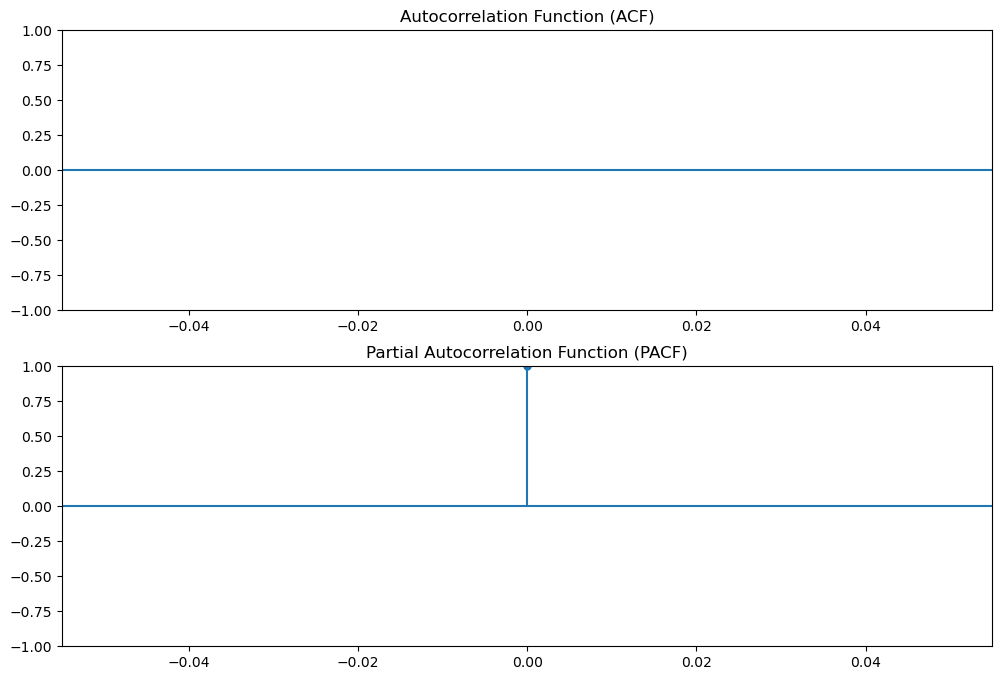

In [46]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF와 PACF 그래프 그리기
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# ACF 그래프
plot_acf(cabbage['price_diff_7'], lags=30, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# PACF 그래프
plot_pacf(cabbage['price_diff_7'], lags=30, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.show()

In [39]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 7일 차분을 적용한 데이터를 생성
train_price_diff = train_selected[['timestamp', f'{item_selected}_가격']].copy().diff(7).dropna()
train_price_diff.set_index('timestamp', inplace = True)

fig, ax = plt.subplots(1,2 ,figsize = (12, 4))

# ACF (AutoCorrelation Function) 그래프 그리기
plot_acf(train_price_diff[f'{item_selected}_가격'], lags=100, title=f'ACF ({item_selected}_가격)_차분', ax=ax[0])

# PACF (Partial AutoCorrelation Function) 그래프 그리기
plot_pacf(train_price_diff[f'{item_selected}_가격'], lags=100, title=f'PACF ({item_selected}_가격_차분)', ax=ax[1])

plt.tight_layout()
plt.show()

KeyError: "['CB_price'] not in index"